<img align="center" src="http://sydney.edu.au/images/content/about/logo-mono.jpg">
<h1 align="center" style="margin-top:10px">Statistical Learning and Data Mining</h1>
<h2 align="center" style="margin-top:20px">Week 9: Decision Trees and Random Forests</h2>
<br>
 
This tutorial shows you how to apply decision trees and random forests to classification problems.
 
<a href="#1.-Work-Analytics-Data">Work analytics data</a> <br>
<a href="#2.-Exploratory-Data-Analysis">Exploratory data analysis</a> <br>
<a href="#3.-Feature-Engineering">Feature engineering</a> <br>
<a href="#4.-Classification-Tree">Classification tree</a> <br>
<a href="#5.-Bagging">Bagging</a> <br>
<a href="#6.-Random-forest">Random forest</a> <br>
<a href="#7.-Interpretation">Interpretation</a> <br>
<a href="#8.-Validation-results">Validation results</a> <br>

This notebook relies on the following libraries and settings.

In [1]:
# Requirements 

import numpy as np
import scipy 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import graphviz
import dtreeviz
import optuna
import shap

print(f'Package versions: \n')

print(f'numpy {np.__version__}')
print(f'scipy {scipy.__version__}')
print(f'pandas {pd.__version__}')
print(f'seaborn {sns.__version__}')
print(f'scikit-learn {sklearn.__version__}')
print(f'graphviz {graphviz.__version__}')
print(f'dtreeviz {dtreeviz.__version__}')
print(f'optuna {optuna.__version__}')
print(f'shap {shap.__version__}')


# Notebook tested on:

# numpy 1.21.5
# scipy 1.7.1
# pandas 1.3.4
# seaborn 0.11.2
# scikit-learn 1.0.2
# graphviz 0.19.1
# dtreeviz 1.3.3
# optuna 2.10.0
# shap 0.40.0

Package versions: 

numpy 1.20.3
scipy 1.7.3
pandas 1.2.5
seaborn 0.11.1
scikit-learn 1.0.2
graphviz 0.16
dtreeviz 1.3.3
optuna 2.9.1
shap 0.39.0


In [2]:
# Optional configuration

# This is to clear the warnings from the notebook, usually we should leave this on
import warnings
warnings.filterwarnings('ignore') 

# Plot settings
sns.set_context('notebook') # optimises figures for notebook display
sns.set_style('ticks') # set default plot style
colours = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', 
           '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(colours) # set custom color scheme
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

In [3]:
# Methods
from sklearn.linear_model import LogisticRegressionCV

# Model selection and evaluation tools
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, average_precision_score, log_loss

# 1. HR Analytics Data

We use the [Human Resources Analytics](https://www.kaggle.com/ludobenistant/hr-analytics) dataset available from [Kaggle Datasets](https://www.kaggle.com/datasets).

Our objective is predict which employees will leave the company with highest possible accuracy (zero-one loss).

In [4]:
data = pd.read_csv('HR.csv')
data = data.rename(columns = {'sales': 'role'})
data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,role,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


As usual, we split the data into training and validation sets.

In [5]:
response = 'left' # whether the employee left the company
predictors = list(data.columns.values)
predictors.remove(response)

index_train, index_valid = train_test_split(np.array(data.index), stratify=data[response], 
                                            train_size=0.7, random_state=5)

train = data.loc[index_train,].copy()
valid = data.loc[index_valid,:].copy()

y_train = train[response]
y_valid = valid[response]

We have over 10,000 training observations. 

In [6]:
len(train)

10499

# 2. Some EDA


## 2.1 Descriptive statistics

About 24% of employees left the company.

In [7]:
train.describe().round(2)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,10499.00,10499.00,10499.00,10499.00,10499.00,10499.00,10499.00,10499.00
mean,0.62,0.72,3.79,200.92,3.51,0.14,0.24,0.02
std,0.25,0.17,1.22,49.74,1.48,0.35,0.43,0.15
min,0.09,0.36,2.00,96.00,2.00,0.00,0.00,0.00
25%,0.44,0.56,3.00,156.00,3.00,0.00,0.00,0.00
50%,0.65,0.72,4.00,200.00,3.00,0.00,0.00,0.00
75%,0.82,0.87,5.00,245.00,4.00,0.00,0.00,0.00
max,1.00,1.00,7.00,310.00,10.00,1.00,1.00,1.00


## 2.2 Numerical predictors

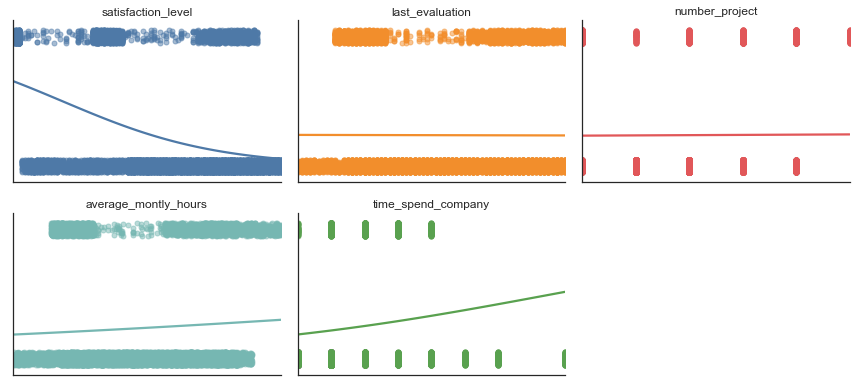

In [8]:
from tutorial9 import plot_logistic_regressions

plot_logistic_regressions(train[predictors].iloc[:,:5], y_train)
plt.show()

## 2.3 Nominal predictors

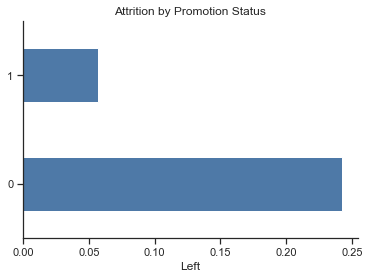

In [9]:
# this code is just for running

table = (train.groupby('promotion_last_5years')['left'].mean()).sort_values(ascending=False).round(3)

fig, ax = plt.subplots(figsize=(6, 4))
table.plot(kind='barh', ax=ax)

ax.set_ylabel('')
ax.set_xlabel('Left')
ax.set_title('Attrition by Promotion Status')

sns.despine()
plt.show()

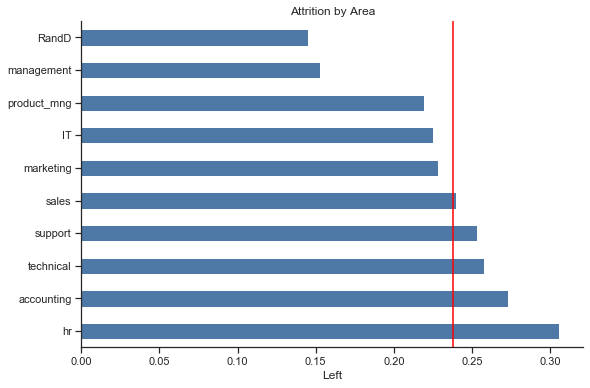

In [15]:
# this code is just for running

table = (train.groupby('role')['left'].mean()).sort_values(ascending=False).round(3)

fig, ax = plt.subplots()
table.plot(kind='barh', ax=ax)

ax.set_ylabel('')
ax.set_xlabel('Left')
ax.set_title('Attrition by Area')

plt.plot([train['left'].mean(), train['left'].mean()], [-1, 10], color="red")

sns.despine()
plt.show()

In [103]:
train['left'].mean()

0.23811791599199925

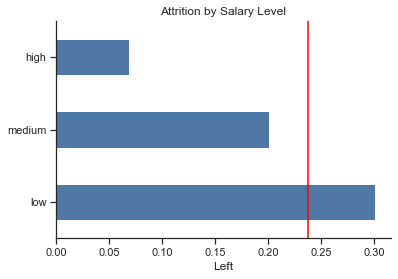

In [106]:
# this code is just for running

table = (train.groupby('salary')['left'].mean()).sort_values(ascending=False).round(3)

fig, ax = plt.subplots(figsize=(6, 4))
table.plot(kind='barh', ax=ax)

ax.set_ylabel('')
ax.set_xlabel('Left')
ax.set_title('Attrition by Salary Level')

plt.plot([train['left'].mean(), train['left'].mean()], [-1, 3], color="red")

sns.despine()
plt.show()

# 3. Feature Engineering

Feature engineering only is a matter of encoding the categorical variables. We use one-hot encoding, but it may also be a good idea to experiment with variations of target encoding for the random forest. 

In [14]:
# this code is just for running

def feat_engineering(df, index_train, index_test):
    
    data = df.copy()
    dummies = pd.get_dummies(data['role'])
    data = data.join(dummies)
    data = data.drop('role', axis= 1)

    dummies = pd.get_dummies(data['salary'],  prefix = 'salary')
    data = data.join(dummies)
    data = data.drop('salary', axis= 1)
    
    features = list(data.columns.values)
    features.remove(response)
    
    X_train = data.loc[index_train, features].copy()
    X_valid =  data.loc[index_valid, features].copy()
    
    return X_train, X_valid, features


X_train, X_valid, feature_names = feat_engineering(data, index_train, index_valid)

# 4. Classification Tree

## 4.1 Growing and visualising a classification tree

The basic syntax for fitting a classification tree is as follows. We start with a small tree with tree leaves for visualisation.

In [46]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(criterion='entropy', max_depth=2)
# clf = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=1000)
clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=2)

You can visualise the decision tree using Graphviz as follows.

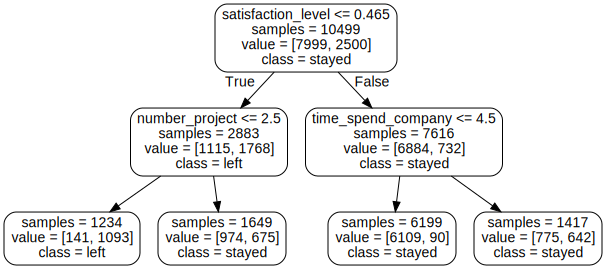

In [47]:
import graphviz
from sklearn.tree import export_graphviz

dot_data = export_graphviz(clf, out_file=None, impurity=False, feature_names=feature_names, 
                           class_names=['stayed','left'], rounded=True) 
graph = graphviz.Source(dot_data)
graph

In [48]:
len(X_train)

10499

In [49]:
train['left'].value_counts()

0    7999
1    2500
Name: left, dtype: int64

Here's an alternative if you can't get Graphviz to work.

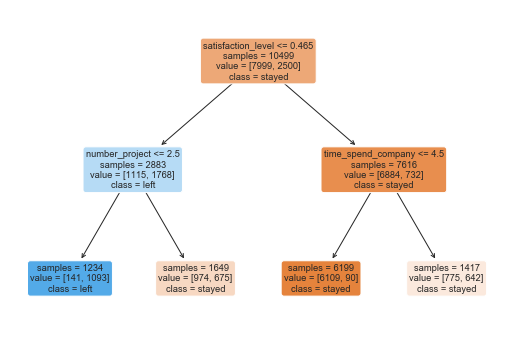

In [50]:
from sklearn.tree import plot_tree

plot_tree(clf, feature_names=feature_names, class_names=['stayed', 'left'], impurity=False,
          rounded=True, filled=True)
plt.show()

In [45]:
split = train.loc[train["satisfaction_level"] >= 0.465]

In [46]:
train.loc[split.index, "left"].mean()

0.09611344537815127

In [47]:
train.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,role,salary
708,0.11,0.87,6,255,4,0,1,0,sales,low
8749,0.15,0.84,3,201,6,0,0,0,support,medium
7339,0.51,0.59,4,187,3,0,0,0,sales,low
10588,0.81,0.64,4,213,3,0,0,0,support,medium
6442,0.36,0.89,3,197,6,0,0,0,hr,medium


The [dtreeviz](https://github.com/parrt/dtreeviz) provides more elaborate decision tree visualisations.

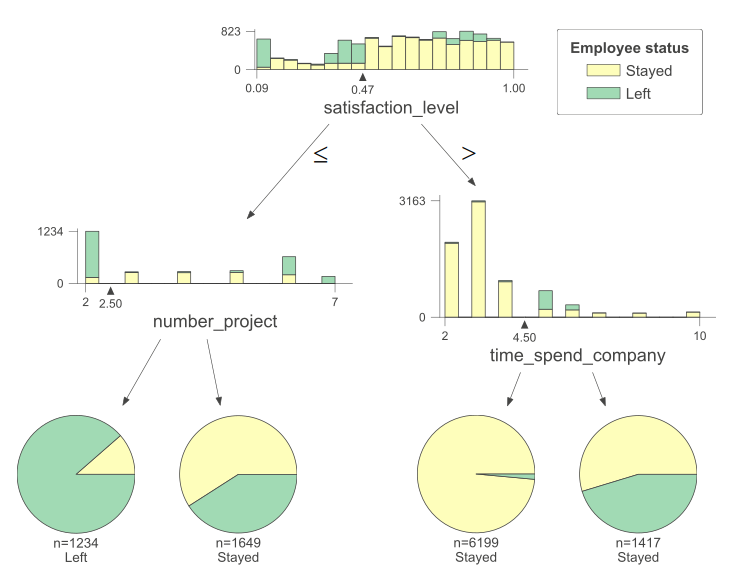

In [51]:
from dtreeviz.trees import *

viz = dtreeviz(clf, X_train, y_train, target_name='Employee status', feature_names=feature_names,
               class_names=['Stayed', 'Left'], scale=2)  
              
viz

Increasing the number of leaves to three allows to visualise how recursive binary splitting grows the tree in a greedy fashion. The top node remains the same as we add a new decision node on the right-hand side.

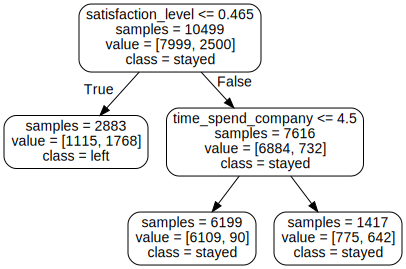

In [52]:
clf = DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=3)
clf.fit(X_train, y_train)

dot_data = export_graphviz(clf, out_file=None , impurity=False, feature_names = feature_names, 
                           class_names=['stayed','left'], rounded=True) 
graph = graphviz.Source(dot_data)
graph

In [55]:
split = train.loc[train["satisfaction_level"] > 0.465]

train.loc[split.index, "left"].value_counts().sort_index()

0    6884
1     732
Name: left, dtype: int64

And here's the dtreeviz visualisation again:

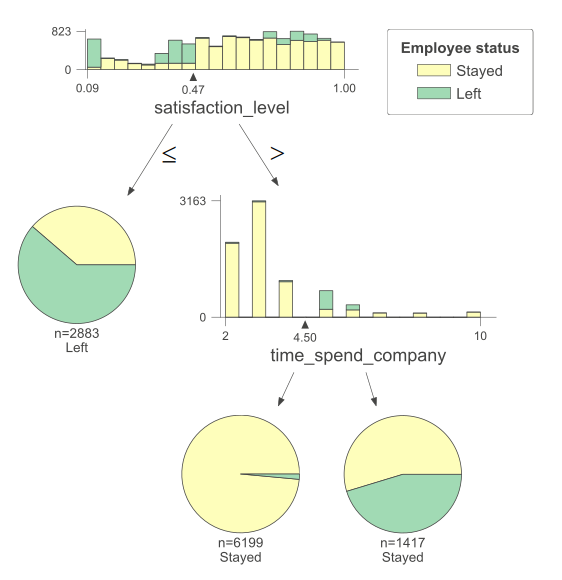

In [53]:
viz = dtreeviz(clf, X_train, y_train, target_name='Employee status', feature_names=feature_names,
               class_names=['Stayed', 'Left'], scale=2)  
              
viz

## 4.2 Cost-complexity pruning

To build a classification tree for prediction, we first grow a large tree by recursive binary splitting and then use cost-complexity criterion to prune it to an optimal size.

To implement this procedure, we first have to run the the following code obtain the relevant grid of values for tree size penalty $\alpha$. Each $\alpha$ corresponds to a smaller version of the large tree.

In [54]:
model = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=5)
path = model.cost_complexity_pruning_path(X_train, y_train)
alphas = path.ccp_alphas

We then run a grid search to find the best $\alpha$.

In [56]:
model = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=5)

search_space = {
    'ccp_alpha': alphas,
}

tree_search = GridSearchCV(model, search_space, cv=5, scoring='neg_log_loss')
tree_search.fit(X_train, y_train)
tree = tree_search.best_estimator_

print('Best parameters found by grid search:', tree_search.best_params_, '\n')

Best parameters found by grid search: {'ccp_alpha': 0.0016680985845902233} 



Here's the final tree:

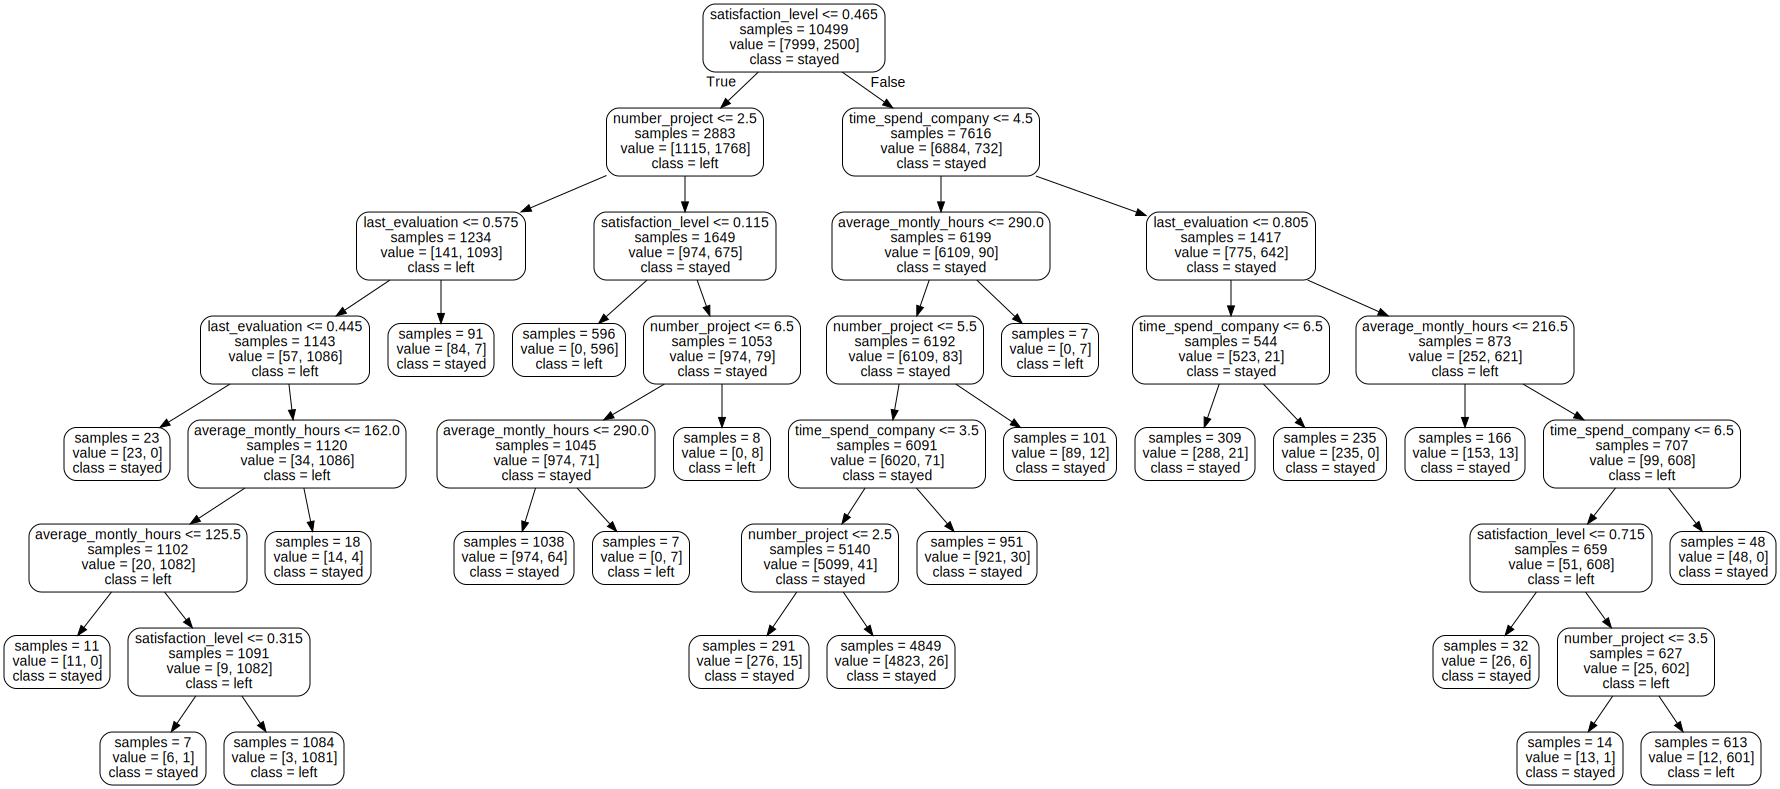

In [57]:
dot_data = export_graphviz(tree, out_file=None , impurity=False, feature_names=feature_names,
                           class_names=['stayed','left'], rounded=True) 
graph = graphviz.Source(dot_data)
graph.render('tree02') # saves tree to a file
graph

# 5. Bagging

Bagging predicts the response by averaging across a large number of trees fitted on different versions of the training set. You can use this method as follows.

In [58]:
from sklearn.ensemble import BaggingClassifier

bag = BaggingClassifier(DecisionTreeClassifier(criterion='entropy'), 
                        n_estimators=1000, random_state=42)
bag.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy'),
                  n_estimators=1000, random_state=42)

# 6. Random forest

## 6.1 Fitting a random forest

The basic syntax o train a random forest is as follows.

In [59]:
from sklearn.ensemble import RandomForestClassifier

rf =  RandomForestClassifier(n_estimators=100, criterion='entropy', max_features=3, min_samples_leaf=5)
rf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_features=3, min_samples_leaf=5)

## 6.2 Hyperparameter optimisation 

We again use optuna for hyperparameter optimisation. The following use the accuracy as the metric for computing the cross-validation error, but the cross-entropy may be more appropriate in other settings where we care more about the quality of the probability estimates. 

In [24]:
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import cross_val_score

def objective(trial):
    
    criterion = trial.suggest_categorical('criterion', ['entropy', 'gini'])
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_int('max_features', 1, 20)
    
    
    model = RandomForestClassifier(n_estimators=100,
                                   criterion=criterion,  
                                   max_features=max_features, 
                                   min_samples_leaf=min_samples_leaf,
                                   random_state=1)
    
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    loss = 1 - np.mean(scores)
    
    return loss

sampler = TPESampler(seed=42)
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(objective, n_trials=100, timeout=120) 

# the timeout should be as high as possible in a real application

[I 2022-03-20 14:02:32,208] A new study created in memory with name: no-name-f6e8b5dd-d2f7-4626-b35a-5f40a54b7717
[I 2022-03-20 14:02:36,396] Trial 0 finished with value: 0.026192835590644115 and parameters: {'criterion': 'gini', 'min_samples_leaf': 15, 'max_features': 12}. Best is trial 0 with value: 0.026192835590644115.
[I 2022-03-20 14:02:42,687] Trial 1 finished with value: 0.014953560652464781 and parameters: {'criterion': 'entropy', 'min_samples_leaf': 2, 'max_features': 18}. Best is trial 1 with value: 0.014953560652464781.
[I 2022-03-20 14:02:50,310] Trial 2 finished with value: 0.01304857188230224 and parameters: {'criterion': 'gini', 'min_samples_leaf': 1, 'max_features': 20}. Best is trial 2 with value: 0.01304857188230224.
[I 2022-03-20 14:02:52,793] Trial 3 finished with value: 0.023049842328546455 and parameters: {'criterion': 'entropy', 'min_samples_leaf': 4, 'max_features': 4}. Best is trial 2 with value: 0.01304857188230224.
[I 2022-03-20 14:02:55,635] Trial 4 finishe

Here are the best hyperparameters:

In [25]:
params = study.best_params
params

{'criterion': 'gini', 'min_samples_leaf': 1, 'max_features': 14}

In [60]:
params = {'criterion': 'gini', 'min_samples_leaf': 1, 'max_features': 14}

In extra material (week 10), we show you how to use combine the above code with the HyperBand method to make hyperparameter optimisation more efficient. 

You should use as many trees as possible when re-fitting the model. We use a thousand here just so that the rest of the code doesn't take too long to run.

In [61]:
 # **params "unpacks" the dictionary and passes the items as inputs to the random forest class
    
rf = RandomForestClassifier(n_estimators=1000, **params)
# rf = RandomForestClassifier(n_estimators=1000, criterion="gini", min_samples_leaf=1, max_features=14)
rf.fit(X_train, y_train)

RandomForestClassifier(max_features=14, n_estimators=1000)

# 7. Interpretation

The disadvantage of random forests is that they much less interpretable than decision trees.  

The next shows you how to compute the SHAP values. In the background, the SHAP package will automatically detect that we want to interpret a tree-based model and use the [TreeExplainer](https://shap-lrjball.readthedocs.io/en/docs_update/generated/shap.TreeExplainer.html) class to calculate the SHAP values. The tree explainer works much faster a than a generic method for computing SHAP values would. 

In [62]:
%%time 

shap.initjs()

explainer = shap.Explainer(rf)
shap_values = explainer.shap_values(X_valid.iloc[:1000, :])

# SHAP needs background data to compute SHAP values
# We use only part of the validation set to save time

CPU times: user 1min 6s, sys: 871 ms, total: 1min 7s
Wall time: 1min 8s


**A key concept to remember is that what we are trying to explain are the model's predictions.** Saying "the model predicts that an employee has low probability of quitting the company because of X" is different from saying that "the employee has low probability of quitting the company because of X". The latter may be what we would truly like to know, but unfortunately supervised learning never justifies causal explanations.

## 7.1 Local explanation


A local explanation means to interpret individual predictions. Below, we use a force plot to analyse the prediction for index 21 of the validation set.

In [63]:
shap.force_plot(explainer.expected_value[1], shap_values[1][21], feature_names = feature_names)

# explainer.expected_value[1] gives the base values for the class with index one (left the company)
# Similarly, shap_values[1] gives the SHAP values for the class with index one (left the company)

Another way to visualise the same information is to make a [waterfall plot](https://shap.readthedocs.io/en/latest/generated/shap.plots.waterfall.html). 

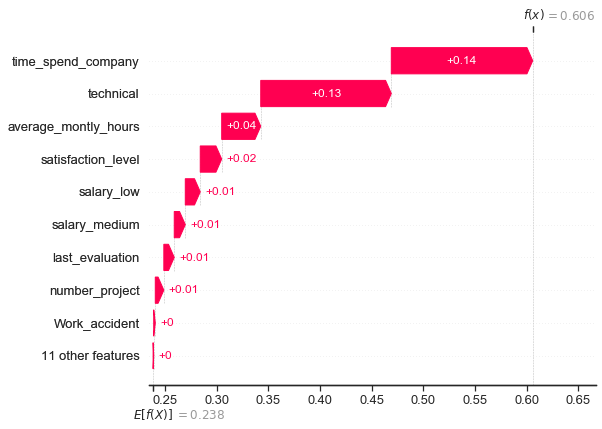

In [72]:
# The current version of the package has a bug, so we use a legacy function as a fix 
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[1], shap_values[1][243, :], 
                                       feature_names=feature_names)

In [66]:
predictions = rf.predict_proba(X_valid)

In [73]:
# 6, 10, 12, 110, 243
predictions[243]

array([0.394, 0.606])

In [74]:
X_valid.iloc[243]

satisfaction_level         0.55
last_evaluation            0.60
number_project             3.00
average_montly_hours     180.00
time_spend_company         4.00
Work_accident              0.00
promotion_last_5years      0.00
IT                         0.00
RandD                      0.00
accounting                 0.00
hr                         0.00
management                 0.00
marketing                  0.00
product_mng                0.00
sales                      0.00
support                    0.00
technical                  1.00
salary_high                0.00
salary_low                 0.00
salary_medium              1.00
Name: 14638, dtype: float64

In [69]:
y_train.mean()

0.23811791599199925

## 7.2 Global explanation

The following figure plots the SHAP values for all the predictions.

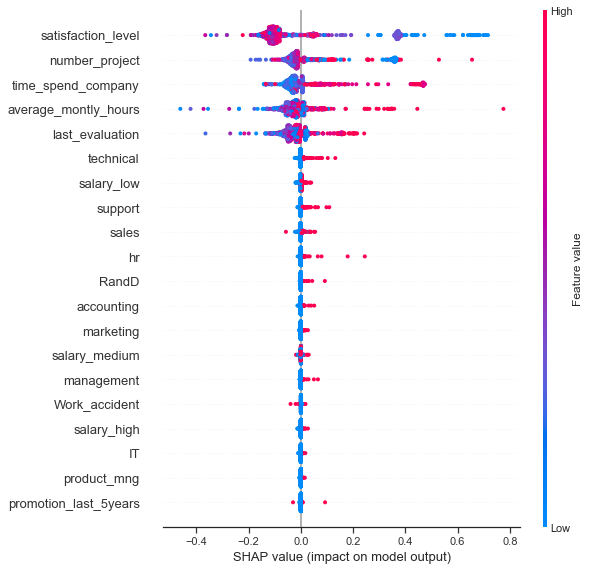

In [30]:
shap.summary_plot(shap_values[1], X_valid.iloc[:1000, :])

Averaging the absolute values of the SHAP values gives a measure of feature importance. 

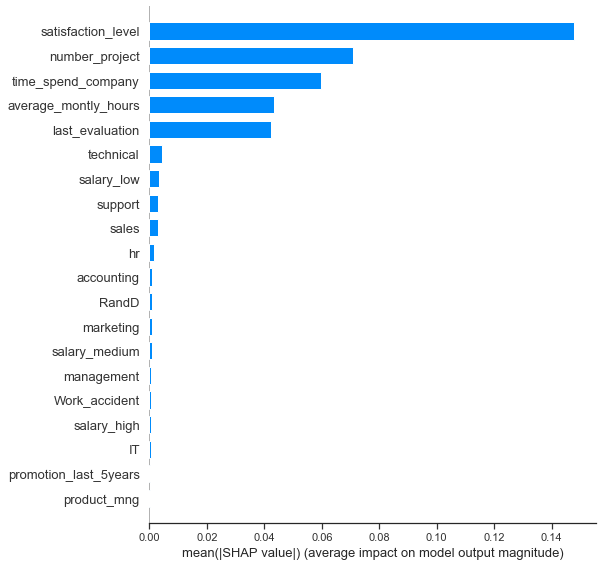

In [31]:
shap.summary_plot(shap_values[1], X_valid.iloc[:1000, :], plot_type = 'bar')

We can also use the standard feature importance measure for trees. The figure below refers to the training set. 

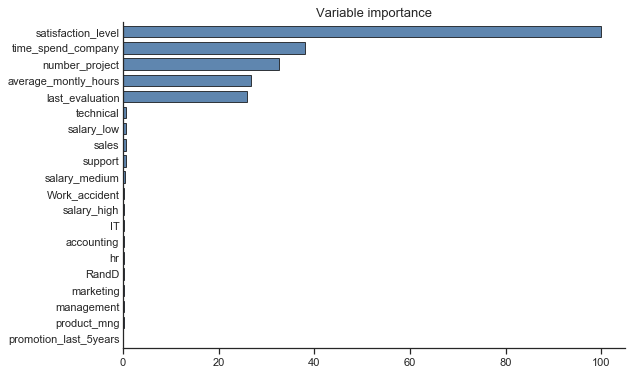

In [32]:
from tutorial9 import plot_feature_importance

plot_feature_importance(rf, feature_names)
plt.show()

# 8. Validation results

Our benchmark will be the logistic regression model:

In [33]:
logit = LogisticRegressionCV()
logit.fit(X_train, y_train)

LogisticRegressionCV()

The results show that the tree-based methods strongly outperform the logistic regression for this dataset. 
Bagging more than halves the error rate compared to a single decision tree. Perhaps because bagging is already very accurate, the random forest only leads to a small additional gain.  

In [34]:
columns=['Error Rate', 'Sensitivity', 'Specificity', 'Precision', 'AUC', 'Cross-entropy']
rows=['Logistic', 'Classification Tree', 'Bagged trees', 'Random forest']
results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods=[logit, tree, bag, rf]

y_prob = np.zeros((len(y_valid), len(rows)))

for i, method in enumerate(methods):
    
    y_prob[:, i] = method.predict_proba(X_valid)[:, 1]
    y_pred = method.predict(X_valid)
        
    tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel() 

    results.iloc[i,0] =   1 - accuracy_score(y_valid, y_pred)
    results.iloc[i,1] =  tp/(tp+fn)
    results.iloc[i,2] =  tn/(tn+fp)
    results.iloc[i,3] =  precision_score(y_valid, y_pred)
    results.iloc[i,4] =  roc_auc_score(y_valid, y_prob[:,i])
    results.iloc[i,5] =  log_loss(y_valid, y_prob[:,i])


results.round(3)

,Error Rate,Sensitivity,Specificity,Precision,AUC,Cross-entropy
Logistic,0.199,0.392,0.928,0.631,0.820,0.428
Classification Tree,0.022,0.920,0.996,0.986,0.982,0.093
Bagged trees,0.010,0.970,0.996,0.988,0.993,0.087
Random forest,0.009,0.970,0.997,0.991,0.994,0.073


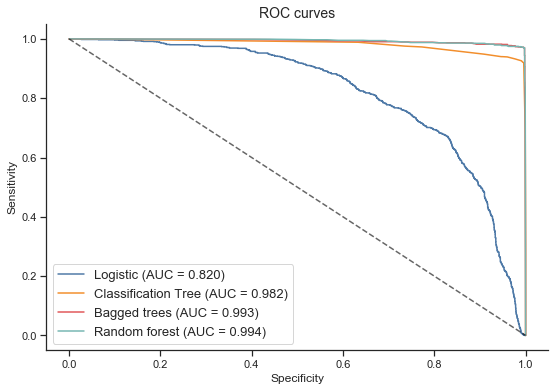

In [35]:
from tutorial9 import plot_roc_curves

fig, ax = plot_roc_curves(y_valid, y_prob, labels=pd.Series(rows))
plt.show()